# Fast track reconstruction in drift tube detectors

#### GROUP 15: Borella Lorenzo, Ceravolo Mattia, Giunta Marco, Lipani Samuele Pio.

## Description

The main goal of our project was to reconstruct the trajectories of charged particles passing through drift tube detectors, as it is represented in the following image:

![alt text](./meantimer.png)

We analyzed data gathered from 4 different detectors, each one having 4 layers made of 16 cells, as it is partially showed in the previous picture. When a charged particle crosses a detector it ionizes the gas inside it, producing an electric signal that is collected by an anodic wire at the center of each cell.

Our initial dataframe was formed by a series of these recorded signals, which will be referred to as "hits" in the following. Starting from this point, we studied the timing and the location of each hit inside a detector in order to associate each of them to a trajectory; a group of hits corresponding to a physical particle trajectory will be referred to as "event" in the following sections of our project.

After having grouped the hits in terms of plausible physical events, we eventually reconstructed the trajectories of the particles.

## Part 0: Preprocessing

The aim of the first part of the project was to transform the original dataframe from a mere collection of hits to a list of ordered physical events. We performed several operations on the original data in order to better associate different hits with unique events. The final result is a dataframe of events that can be eventually used to reconstruct the trajectories of the particles.

## Data Aquisition

The raw data are just a collection of hits, corresponding to each line of the initial dataframe. The values of **FPGA** and **TDC_CHANNEL** are useful to identify the detectors in which the hit occured and the position of the hit inside the detector, the values of **ORBIT_CNT**, **BX_COUNTER** and **TDC_MEAS** instead are useful to determine the timing of each hit with respect to the beginning of the experiment.

In the original dataframe there are also lines not explicitly corresponding to the passage of a particle in a cell. These lines, identified by the values of **TDC_CHANNEL=137,138,139**, correspond to the activation of two different trigger systems: an electronic trigger (139) and two scintillators (137,138). In the following sections of the project, the information brought by the trigger activations will be fundamental to reconstruct the correct position of the particles inside each cell.

The electronic trigger is activated when at least two close cells register the passage of a particle, while the scintillators are placed parallel to the layers and get activated whenever a particle hits the detector. 
Due to the different functioning of these systems, and due to the overall majority of electronic trigger activations, we decided to maintain only the latter as reliable trigger system in our analysis.

In [1]:
import pandas as pd
import numpy as np
import timeit as t
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import optimize

import time

In [2]:
dataset = pd.read_csv("data_000000.txt")

samples = dataset.shape[0]
print("Number of total hits:",samples)

ntriggers = dataset[(dataset['TDC_CHANNEL'] == 137) | (dataset['TDC_CHANNEL'] == 138)].shape[0]
triggers = dataset[dataset['TDC_CHANNEL'] == 139].shape[0]
print("Number of trigger 139 activations:",triggers)
print("Percentage of trigger 139 wrt the total", triggers/samples*100,"%")
print("Percentage of trigger 137-8 wrt the total", ntriggers/samples*100,"%")

total_orbits = dataset['ORBIT_CNT'].nunique()
print("Number of unique orbits:",total_orbits)

display(dataset)


Number of total hits: 1292126
Number of trigger 139 activations: 95258
Percentage of trigger 139 wrt the total 7.372191256889808 %
Percentage of trigger 137-8 wrt the total 0.18930042426203017 %
Number of unique orbits: 481613


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,1,116,1897414884,1533.0,24.0
1,1,1,71,1897414887,1650.0,21.0
2,1,1,67,1897414914,980.0,8.0
3,1,1,70,1897414922,1287.0,8.0
4,1,0,57,1897414922,2162.0,22.0
...,...,...,...,...,...,...
1292121,1,1,139,1920940255,2514.0,0.0
1292122,1,1,35,1920940255,2512.0,16.0
1292123,1,1,37,1920940255,2513.0,5.0
1292124,1,1,105,1920940255,2510.0,17.0


## Implementing the Dataframe

In order to better visualize the spatial distribution of the hits inside the detectors, we translated the informations of the original dataframe in more comprehensible coordinates. 

We added the **TIME** column, which contains the time coordinate of each hit in nanoseconds, calculated with the following formula, not considering the **ORBIT_CNT** value:

$$
TIME=25\cdot BX\_COUNTER + TDC\_MEAS \cdot 25/30
$$

We associated a **DETECTOR** value for each hit, deriving it from the mapping:

* Detector 1 $\rightarrow$ FPGA 0, TDC_CHANNEL in [1-64]
* Detector 2 $\rightarrow$ FPGA 0, TDC_CHANNEL in [65-128]
* Detector 3 $\rightarrow$ FPGA 1, TDC_CHANNEL in [1-64]
* Detector 4 $\rightarrow$ FPGA 1, TDC_CHANNEL in [65-128]

Then we added a **LAYER** coordinate to each hit, based on the numbering of the cells of each detector.
For the trigger activations we associated a meaningless value 0 for both **DETECTOR** and **LAYER** columns. Eventually, we dropped the **FPGA** and **HEAD** columns which were no longer useful for our project.

In [3]:
#TIME
dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30

#DETECTOR
fpga = dataset['FPGA'] == 1 
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] <= 128) 
trigger = dataset['TDC_CHANNEL'] == 139

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel] 
for i in range(len(detectors)) : dataset.loc[detectors[i],'DETECTOR'] = i+1

dataset.loc[trigger,'DETECTOR'] = 0

#delete useless channels
for i in [129,130,137,138]:dataset.drop(dataset[dataset['TDC_CHANNEL']==i].index)

#LAYER
rest = dataset['TDC_CHANNEL'] % 4 
dic_replace = {0:1, 2:2, 3:3, 1:4}

dataset['LAYER'] = rest
dataset['LAYER'].replace(dic_replace, inplace=True)

dataset.loc[trigger,'LAYER'] = 0 

#HEAD,FPGA
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

dataset

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,116,1897414884,1533.0,24.0,38345.000000,4.0,1
1,71,1897414887,1650.0,21.0,41267.500000,4.0,3
2,67,1897414914,980.0,8.0,24506.666667,4.0,3
3,70,1897414922,1287.0,8.0,32181.666667,4.0,2
4,57,1897414922,2162.0,22.0,54068.333333,1.0,4
...,...,...,...,...,...,...,...
1292121,139,1920940255,2514.0,0.0,62850.000000,0.0,0
1292122,35,1920940255,2512.0,16.0,62813.333333,3.0,3
1292123,37,1920940255,2513.0,5.0,62829.166667,3.0,4
1292124,105,1920940255,2510.0,17.0,62764.166667,4.0,4


## Identification of events

As a first approach to identify physical events, we required the hits to be sufficiently close in time. In order to do this, we firstly grouped the hits by common values of **ORBIT_CNT**. Since there is a small but non-zero probability to have multiple events in the same orbit, we then applied a time-proximity function that recognizes the different events happening in the same orbit.

After having grouped the hits by time proximity, we performed a series of cuts by imposing specific conditions on our data, with the aim to obtain a clean set of events with the characteristics required by the following parts of our project.

In [4]:
#identify mutiple events inside the same orbit

def Identify_Events(x):
    
    if (x.TIME.max() - x.TIME.min()) < 415:
    
        x['EVENT'] = 1
        return x
    
    else:
        
        t1 = x.TIME.iloc[0]
        x1 =  x[np.abs(x.TIME.values - t1) < 415]
        x1['EVENT'] = 1
        
        xc = x[np.abs(x.TIME.values - t1) >= 415]
        i = 1
        while(xc.size != 0):
            
            i += 1
            t2 = xc.TIME.iloc[0]
            x2 =  xc[np.abs(xc.TIME.values - t2) < 415]
            x2['EVENT'] = i
            x1 = pd.concat([x1,x2])
            xc = xc[np.abs(xc.TIME.values - t2) >= 415]
        
        return x1

In [5]:
filtered1 = dataset.groupby('ORBIT_CNT', group_keys=False).apply(Identify_Events)
filtered1

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,116,1897414884,1533.0,24.0,38345.000000,4.0,1,1
1,71,1897414887,1650.0,21.0,41267.500000,4.0,3,1
2,67,1897414914,980.0,8.0,24506.666667,4.0,3,1
3,70,1897414922,1287.0,8.0,32181.666667,4.0,2,1
4,57,1897414922,2162.0,22.0,54068.333333,1.0,4,2
...,...,...,...,...,...,...,...,...
1292120,101,1920940255,2510.0,14.0,62761.666667,4.0,4,1
1292121,139,1920940255,2514.0,0.0,62850.000000,0.0,0,1
1292122,35,1920940255,2512.0,16.0,62813.333333,3.0,3,1
1292123,37,1920940255,2513.0,5.0,62829.166667,3.0,4,1


In [6]:
events1 = filtered1.groupby(['ORBIT_CNT','EVENT']).nunique()
print("Number of unique events:", len(events1))
print("Samples in reduced dataset:", len(filtered1))
print("Percentage of the original dataset:", len(filtered1)*100/samples,"%")



Number of unique events: 531000
Samples in reduced dataset: 1292125
Percentage of the original dataset: 99.9999226081667 %


## First cut: length

Since we had to associate each event to a linear trajectory, we decided to keep only the events that contained at least three hits in the same orbit time span (not considering the trigger lines) and delete the ones that didn't satisfy this requirement. We choosed exactely three hits because, in the part of the project where we need to solve the ambiguity of the position for the particle inside the cell, it would have been impossible to distinguish the correct trajectory between multiple sets of two points.  In order to do this, we grouped the hits with the method `groupby(['ORBIT_CNT', 'EVENT'])` and we applied the function `cut(group)` to each group, since it resulted to be the less computationally demanding procedure.

The result of this cut lead us to a smaller dataframe, around the 61% of the original one. By counting the numbers of unique **ORBIT_CNT** values and of the total trigger activations, we realized that there are orbits in which the triggers are never activated. Since the trigger activation is fundamental to define the passage of a particle as we mean it, we must delete the cases in which there is not such activation.

In [7]:
#function to cut groups smaller than 3 hits
def cut(group) :

    if group.shape[0] > 3 : return group #considering the trigger activations
    else : return None

#filter dataset by length                          
filtered2=filtered1.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                 .apply(cut)\
                 .dropna()\
                 .reset_index()\
                 .drop(['index'],axis=1)

orbits2 = len(filtered2.groupby(['ORBIT_CNT', 'EVENT']).nunique())

print("Number of unique events:", orbits2)
print("Samples in reduced dataset:", filtered2.shape[0])
print("Percentage of the original dataset:", filtered2.shape[0]*100/samples,"%")


if orbits2 > triggers : print("\n NOTE:There are orbits with no trigger activation!") #check

filtered2

Number of unique events: 102382
Samples in reduced dataset: 790585
Percentage of the original dataset: 61.18482253278705 %

 NOTE:There are orbits with no trigger activation!


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0,1.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0,1.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0,1.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...
790580,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0,1.0
790581,139.0,1.920940e+09,2514.0,0.0,62850.000000,0.0,0.0,1.0
790582,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0,1.0
790583,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0,1.0


## Second cut: trigger activation

In order to proceed in our project, we had to collect events bringing with them the time information of the trigger activation: this will be fundamental in the following to calculate the distance of the particle from the center of each cell. Therefore, in the second cut we deleted the events that did not contain a trigger activation inside them.

We performed this by grouping the hits with the method `groupby(['ORBIT_CNT', 'EVENT']` and applying the function `trigger(group)` to each group. The final result is a reduced dataframe, about the 58% of the original one.

In [8]:
#function that selects events with trigger activation
def trigger(group) :
    if (group['DETECTOR'] != 0).all() : return None
    else : return group
    
#filter dataset by trigger activation                                      
filtered3 = filtered2.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(trigger)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)


orbits3 = len(filtered3.groupby(['ORBIT_CNT', 'EVENT']).nunique())
print("Number of unique events:", orbits3)
print("Samples in reduced dataset:", filtered3.shape[0])
print("Percentage of the original dataset:", filtered3.shape[0]*100/samples,"%")

filtered3

Number of unique events: 94428
Samples in reduced dataset: 751055
Percentage of the original dataset: 58.125523362272716 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0,1.0
2,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0,1.0
3,139.0,1.897415e+09,2028.0,0.0,50700.000000,0.0,0.0,1.0
4,33.0,1.897415e+09,2026.0,14.0,50661.666667,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...
751050,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0,1.0
751051,139.0,1.920940e+09,2514.0,0.0,62850.000000,0.0,0.0,1.0
751052,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0,1.0
751053,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0,1.0


Before going on with other cuts, we sorted the hits inside each group by their time values in ascending order, since we wanted to better visualize the time distribution of the hits with respect to their spatial distribution inside the detector.

In [9]:
#sort each event by time
ordered = filtered3.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                   .apply(lambda x: x.sort_values(['TIME']))\
                   .reset_index()\
                   .drop(['index'],axis=1)

ordered

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0,1.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0,1.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0,1.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...
751050,102.0,1.920940e+09,2510.0,22.0,62768.333333,4.0,2.0,1.0
751051,38.0,1.920940e+09,2512.0,10.0,62808.333333,3.0,2.0,1.0
751052,35.0,1.920940e+09,2512.0,16.0,62813.333333,3.0,3.0,1.0
751053,37.0,1.920940e+09,2513.0,5.0,62829.166667,3.0,4.0,1.0


## Third cut: cleaning events

We also had to treat the cases in which more events happen in the same orbit. One could choose to simply delete these cases out of the dataframe, since they are not so numerous and they don't contribute to our analysis with a significant weight. We choosed instead to keep and clean them, trying to recognise the different events happening in the same orbit by means of **DETECTOR** and **TIME** values.

As always we performed this by grouping the hits with the method `groupby(['ORBIT_CNT', 'EVENT']` and applying the function `clean(group)` to each group. The latter identifies the most common detector value inside one orbit and deletes the hits not corresponding to this value, delivering a dataframe of cleaner and simpler events.

This selection returns a reduced dataframe of about the 41% of the original one.

In [10]:
#function that cleans the events
def clean(group):
    
    group1 = group.drop(group[group['DETECTOR'] == 0].index) #event without trigger
    
    detector = group1.DETECTOR.mode().values #value of most common detector
    
    indices = group1[group1['DETECTOR'] != detector[0]].index #indices of hits not corresponding to most common detector
    group = group.drop(indices) #clean event
    
    return group

#clean the events
filtered4 = ordered.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                   .apply(clean)\
                   .dropna()\
                   .reset_index()\
                   .drop(['index'],axis=1)


orbits4 = len(filtered4.groupby(['ORBIT_CNT', 'EVENT']).nunique())
hits4 = filtered4.shape[0]
print("Number of unique orbits:", orbits4)
print("Samples in reduced dataset:", hits4)
print("Percentage of the original dataset:", hits4*100/samples,"%")


filtered4

Number of unique orbits: 94428
Samples in reduced dataset: 542148
Percentage of the original dataset: 41.95782764219589 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0,1.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0,1.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0,1.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...
542143,106.0,1.920940e+09,2507.0,24.0,62695.000000,4.0,2.0,1.0
542144,101.0,1.920940e+09,2510.0,14.0,62761.666667,4.0,4.0,1.0
542145,105.0,1.920940e+09,2510.0,17.0,62764.166667,4.0,4.0,1.0
542146,102.0,1.920940e+09,2510.0,22.0,62768.333333,4.0,2.0,1.0


For completeness, we repeated the selection of the hits with the function `cut(group)`, since after the previous "cleaning" some of the events could have gained a different and not required length. This process doesn't change much our dataframe, but it allows us to continue our analysis with a set of events satisfying our specific conditions.

In [11]:
filtered4 = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(cut)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)

orbits4 = len(filtered4.groupby(['ORBIT_CNT', 'EVENT']).nunique())
hits4 = filtered4.shape[0]
print("Number of unique orbits:", orbits4)
print("Samples in reduced dataset:", hits4)
print("Percentage of the original dataset:", hits4*100/samples,"%")


Number of unique orbits: 94082
Samples in reduced dataset: 541110
Percentage of the original dataset: 41.877494919226145 %


## Fourth cut: layers

Proceeding with our analysis, we made some considerations about the layers activated in each event, since we wanted to keep events that can surely be associated to the passage of a particle in the detectors.

We counted the events that have at least one cell activated per layer: we found out that the 95% of the events that we previously selected satisfy this requirement, the remaining 5% instead contains events with only three activated layers. Since the detector it's not perfect, it is possible that a cell failed to register a signal, therefore we decided to still consider these particular cases as plausible physical events.

In [12]:
#function that counts events with all layers activated
def countlayers(group):
    if group['LAYER'].nunique() > 4: return group #considering the trigger lines
    else: return None
    
#count the events
morethan3df = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                       .apply(countlayers)\
                       .dropna()\
                       .reset_index()\
                       .drop(['index'],axis=1)

morethan3orbits = len(morethan3df.groupby(['ORBIT_CNT', 'EVENT']).nunique())
print("Events having all four layers activated are:",morethan3orbits/orbits4*100,"% wrt the previous filtering procedure")

Events having all four layers activated are: 95.67398652239535 % wrt the previous filtering procedure


The events in the remaining 5% of the dataframe must contain only 3 layers activated. Between these 3-layer cases we are considering either the events that have 3 activated layers next to eachother and the ones which report a non-active cell between other activated cells, carrying a "hole" in the representation of the possible trajectory. We checked this possibility by counting these types of events and we found out that the events with "holes" in their trajectories are just the 0.6% of our dataframe.

In [13]:
#function that selects holes
def hole(group):
    if group['LAYER'].nunique() < 5: 
        if ((group['LAYER']==1).any())and((group['LAYER']==2).any())and((group['LAYER']==4).any()) : return group
        elif ((group['LAYER']==1).any())and((group['LAYER']==3).any())and((group['LAYER']==4).any()) : return group
        else : return None
    else : return None
    
#select events with holes
holes = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                 .apply(hole)\
                 .dropna()\
                 .reset_index()\
                 .drop(['index'],axis=1)


orbits = len(holes.groupby(['ORBIT_CNT', 'EVENT']).nunique())
hits = holes.shape[0]
print("Number of unique orbits:", orbits)
print("Samples in reduced dataset:", hits)
print("Percentage of the original dataset:", hits*100/samples,"%")

holes

Number of unique orbits: 1855
Samples in reduced dataset: 8196
Percentage of the original dataset: 0.634303465761079 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,40.0,1.897449e+09,1599.0,20.0,39991.666667,1.0,1.0,1.0
1,37.0,1.897449e+09,1603.0,27.0,40097.500000,1.0,4.0,1.0
2,38.0,1.897449e+09,1604.0,12.0,40110.000000,1.0,2.0,1.0
3,139.0,1.897449e+09,1606.0,0.0,40150.000000,0.0,0.0,1.0
4,126.0,1.897540e+09,985.0,16.0,24638.333333,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...
8191,79.0,1.920940e+09,3364.0,23.0,84119.166667,2.0,3.0,1.0
8192,80.0,1.920940e+09,3366.0,26.0,84171.666667,2.0,1.0,1.0
8193,77.0,1.920940e+09,3373.0,25.0,84345.833333,2.0,4.0,1.0
8194,81.0,1.920940e+09,3375.0,28.0,84398.333333,2.0,4.0,1.0


After having performed this check, we keep all the events which have at least three different layers activated: we will treat separately the previously mentioned different cases in the following sections.

In [14]:
#function that selects groups with at least 3 layers activated (keeping the holes)
def all_layers(group) :
    if group['LAYER'].nunique() > 3 : return group #considering the trigger lines
    else : return None

#filter by layers
filtered5 = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(all_layers)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1) 


orbits5 = len(filtered5.groupby(['ORBIT_CNT', 'EVENT']).nunique())

print("Number of unique orbits:", orbits5)
print("Samples in reduced dataset:", filtered5.shape[0])
print("Percentage of the original dataset:", filtered5.shape[0]*100/samples,"%")


filtered5

Number of unique orbits: 93939
Samples in reduced dataset: 540383
Percentage of the original dataset: 41.821231056414 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,24.0,1.897415e+09,2014.0,13.0,50360.833333,1.0,1.0,1.0
1,26.0,1.897415e+09,2014.0,20.0,50366.666667,1.0,2.0,1.0
2,27.0,1.897415e+09,2024.0,11.0,50609.166667,1.0,3.0,1.0
3,29.0,1.897415e+09,2026.0,9.0,50657.500000,1.0,4.0,1.0
4,26.0,1.897415e+09,2026.0,13.0,50660.833333,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...
540378,26.0,1.920940e+09,545.0,21.0,13642.500000,3.0,2.0,1.0
540379,25.0,1.920940e+09,546.0,2.0,13651.666667,3.0,4.0,1.0
540380,139.0,1.920940e+09,548.0,0.0,13700.000000,0.0,0.0,1.0
540381,24.0,1.920940e+09,550.0,20.0,13766.666667,3.0,1.0,1.0


## Fifth cut: verticality   

At this point of the analysis we decided to delete the events that carry more activated cells inside the same layer. The detectors are sensibile to particle trajectories which are almost vertical, therefore we didn't expect to find a considerable number of nearly horizontal events, nontheless the activation of multiple cells inside the same layer could have lead us to consistent problems when trying to reconstruct the physical trajectories of the particles. The cases in which multiple hits occur on the same layer are interpreted as noisy events and therefore deleted.

This choice cuts off about the 15% of our dataframe but allows us to proceed with a set of events that satisfy the requirements of our project. The remaining data are about the 26% of the original dataframe.

In [15]:
#function that requires the verticality of the events
def more_layers(group) : 
    if len(group['LAYER']) != len(set(group['LAYER'])) : return None 
    else : return group
    
#filter the dataframe
filtered6 = filtered5.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(more_layers)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)

orbits6 = len(filtered6.groupby(['ORBIT_CNT', 'EVENT']).nunique())

print("Number of unique orbits:", orbits6)
print("Samples in reduced dataset:", filtered6.shape[0])
print("Percentage of the original dataset:", filtered6.shape[0]*100/samples,"%")

filtered6

Number of unique orbits: 69281
Samples in reduced dataset: 343723
Percentage of the original dataset: 26.601353118813492 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,87.0,1.897415e+09,2798.0,9.0,69957.500000,2.0,3.0,1.0
1,86.0,1.897415e+09,2802.0,27.0,70072.500000,2.0,2.0,1.0
2,89.0,1.897415e+09,2807.0,27.0,70197.500000,2.0,4.0,1.0
3,88.0,1.897415e+09,2810.0,24.0,70270.000000,2.0,1.0,1.0
4,139.0,1.897415e+09,2812.0,0.0,70300.000000,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
343718,26.0,1.920940e+09,545.0,21.0,13642.500000,3.0,2.0,1.0
343719,25.0,1.920940e+09,546.0,2.0,13651.666667,3.0,4.0,1.0
343720,139.0,1.920940e+09,548.0,0.0,13700.000000,0.0,0.0,1.0
343721,24.0,1.920940e+09,550.0,20.0,13766.666667,3.0,1.0,1.0


## Visualization of events

In order to visually check the type of events that we were treating, we produced a graphical method to plot every event inside the detector. We built 3 different functions to achieve this:

* `centres`: calculates the coordinates (x,y) of the centres of the cells.
* `boxes`: prints red boxes around the activated cells in the detector.
* `draw_detector`: draws all the cells of the detector.

In [16]:
#function to draw hit cells
def centres(ev):
    
    ev=ev.drop(ev[ev['DETECTOR'] == 0].index).reset_index().drop(['index'],axis=1) #drop the trigger hit
    
    dx=1
    dy=1/2
    
    x = np.zeros(ev.shape[0])
    y = np.zeros(ev.shape[0])

    if (ev['TDC_CHANNEL']>64).all() : ev['TDC_CHANNEL'] -= 64

    #calculate coordinates of centers
    for i in range(ev.shape[0]): 
        
        layer = ev.loc[i,'LAYER']
        channel = ev.loc[i,'TDC_CHANNEL']

        if layer == 1 : 
            x[i] = channel/4
            y[i] = 1/4
        
        elif layer == 2 :
            x[i] = (channel+2)/4 + dx/2 
            y[i] = 3/4 
        
        elif layer == 3 :
            x[i] = (channel+1)/4
            y[i] = 5/4
        
        elif layer == 4 : 
            x[i] = (channel+3)/4 + dx/2 
            y[i] = 7/4
        
            
    return [x,y]


In [17]:
#function to draw the activated cells
def boxes(ax,x,y):
    
    dx = 1
    dy = 1/2
     
    for i in range(len(x)) :
        rect = patches.Rectangle((x[i]-dx/2,y[i]-dy/2),dx,dy,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)


In [18]:
#function to draw the detector
def draw_detector(ax) :
    
    dx = 1
    dy = 1/2

    ax.set_xlim(0,16.5)
    ax.set_ylim(-0.2,2.2)

    #coordinates of layer 1
    x_1 = np.arange(1,16)-dx/2
    y_1 = 0
    
    #coordinates of layer 2
    x_2 = x_1 + dx/2
    y_2 = dy
    
    #coordinates of layer 3
    x_3 = x_1 
    y_3 = 2*dy
    
    #coordinates of layer 4
    x_4 = x_2
    y_4 = 3*dy
    
    for i in range(15): 
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        ax.axis('off')


We choosed 6 events from our dataframe and represented them graphically. In this way we have the chance to check their distribution inside the detector and the rightfulness of our previous choices.

In [19]:
events = [value for value in filtered6.groupby(['ORBIT_CNT', 'EVENT']).groups.values()]
triggers_139 = filtered6[filtered6['TDC_CHANNEL']==139]
event = [filtered6.loc[events[i]].drop(triggers_139.iloc[i].name) for i in range(6)]
event[4]

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
20,40.0,1.897416e+09,1477.0,21.0,36942.500000,1.0,1.0,1.0
21,38.0,1.897416e+09,1479.0,19.0,36990.833333,1.0,2.0,1.0
22,35.0,1.897416e+09,1481.0,26.0,37046.666667,1.0,3.0,1.0
23,33.0,1.897416e+09,1484.0,15.0,37112.500000,1.0,4.0,1.0


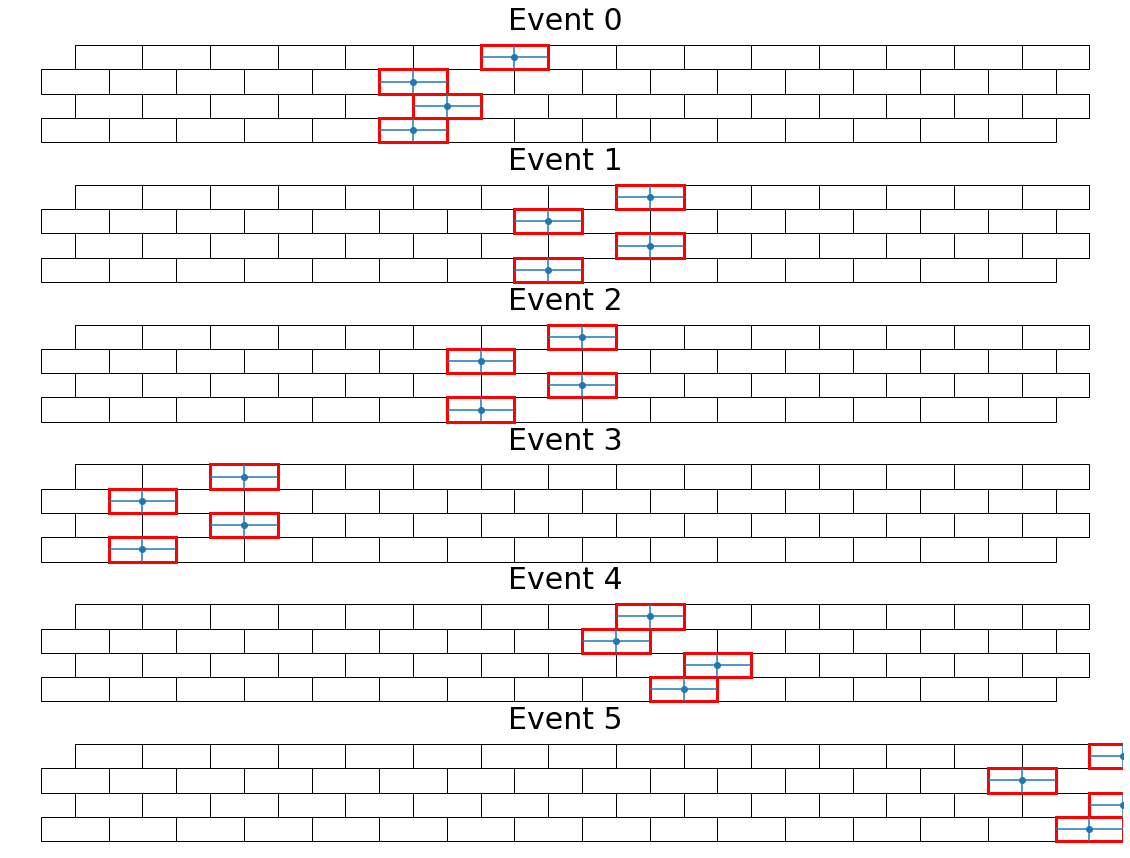

In [20]:
#draw events
dx = 1
dy = 1/2

fig,ax = plt.subplots(nrows=6,ncols=1,figsize=(20,15))

for i in range(6):
    ax[i].set_title("Event %d" %i,fontsize=30)
    draw_detector(ax[i])
    boxes(ax[i],centres(event[i])[0],centres(event[i])[1])
    ax[i].errorbar(*centres(event[i]),dy/2,dx/2,fmt='o')

plt.show()


## Sixth cut: horizontal proximity

As we can see from the previous images, the majority of the events that we had selected so far still couldn't represent linear trajectories of particles: we had to impose a constraint on the horizontal coordinates of the activated cells in the different layers.

In order to do this we had to distinguish the normal events cases from the ones with holes, therefore we wrote two dedicated functions to impose the horizontal proximity constraint:

* `close`: sorts the hits by **LAYER**, computes the differences between the coordinates of the centers of each activated cell and returns the event only if these differences are sufficiently small. This method is not meant to be applied on the events with holes.

* `close_holes`: treats each possible configurations of the events with holes and applies a different type of horizontal proximity constraint.

After having separately applied these functions, we merged the two resulting dataframes into the final optimal one.

### Normal events

In [21]:
#function that select only cells that are close in the detector
def close(group):
    
    group1 = group.drop(group[group['DETECTOR']==0].index)\
                  .sort_values('LAYER') #event without trigger and sorted by LAYER
    
    x = pd.Series(centres(group1)[0]).diff().abs() #distances between cells
    
    if (x>1).any() == True: return None
    else : return group
    
    
#apply horizontal proximity
filtered7 = filtered6.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(close)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1) 


orbits7 = len(filtered7.groupby(['ORBIT_CNT', 'EVENT']).nunique())

print("Number of unique orbits:",orbits7)
print("Samples in reduced dataset:",filtered7.shape[0])
print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")


filtered7

Number of unique orbits: 28864
Samples in reduced dataset: 142920
Percentage of the original dataset: 11.06084081583375 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,1.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,1.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0,1.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...
142915,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,1.0
142916,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,1.0
142917,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0,1.0
142918,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,1.0


### Events with holes

In [22]:
#function that imposes horizontal proximity for events WITH HOLES
def close_holes(group):
    group1 = group.drop(group[group['DETECTOR'] == 0].index)\
    .sort_values('LAYER') #event without trigger and sorted by LAYER
    
    #distances between cells
    x = pd.Series(centres(group1)[0]).diff().abs()
    
    #possible events with holes
    case1=pd.Series([None, 1, 2])
    case2=pd.Series([None, 2, 1])
    case3=pd.Series([None, 0, 1])
    case4=pd.Series([None, 1, 0])
    
    if (x==case1).all() or (x==case2).all() or (x==case3).all() or (x==case4).all(): return group  
    else : return None


In [23]:
#select only events with holes
holes1 = filtered6.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                  .apply(hole)\
                  .dropna()\
                  .reset_index()\
                  .drop(['index'],axis=1)


orbits = len(holes1.groupby(['ORBIT_CNT', 'EVENT']).nunique())

print("Number of unique orbits:",orbits)
print("Samples in reduced dataset:",holes1.shape[0])
print("Percentage of the original dataset:",holes1.shape[0]*100/samples,"%")

holes1

Number of unique orbits: 1359
Samples in reduced dataset: 5436
Percentage of the original dataset: 0.42070200584153555 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,40.0,1.897449e+09,1599.0,20.0,39991.666667,1.0,1.0,1.0
1,37.0,1.897449e+09,1603.0,27.0,40097.500000,1.0,4.0,1.0
2,38.0,1.897449e+09,1604.0,12.0,40110.000000,1.0,2.0,1.0
3,139.0,1.897449e+09,1606.0,0.0,40150.000000,0.0,0.0,1.0
4,29.0,1.897542e+09,2163.0,15.0,54087.500000,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...
5431,93.0,1.920940e+09,1549.0,9.0,38732.500000,4.0,4.0,2.0
5432,125.0,1.920940e+09,779.0,13.0,19485.833333,2.0,4.0,1.0
5433,127.0,1.920940e+09,783.0,22.0,19593.333333,2.0,3.0,1.0
5434,128.0,1.920940e+09,791.0,22.0,19793.333333,2.0,1.0,1.0


In [24]:
#treat events with holes with closep (fails if filteredholes is empty)
try:
    filteredholes = holes1.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                          .apply(close_holes)\
                          .dropna()\
                          .reset_index()\
                          .drop(['index'],axis=1)

    orbits = len(filteredholes.groupby(['ORBIT_CNT', 'EVENT']).nunique())

    print("Number of unique orbits:",orbits)
    print("Samples in reduced dataset:",filteredholes.shape[0])
    print("Percentage of the original dataset:",filteredholes.shape[0]*100/samples,"%")

    filteredholes


    filtered7 = pd.concat([filtered7,filteredholes],ignore_index=True) #merge holes and normal events
    orbits7 = len(filtered7.groupby(['ORBIT_CNT', 'EVENT']).nunique())

    print("Number of unique orbits:",orbits7)
    print("Samples in reduced dataset:",filtered7.shape[0])
    print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")

    filtered7
    
except: pass

## Final Dataframe

The final version of our dataframe corresponds to the 11% of the original amount of data. This strong reduction can be justified by the long series of constraints that we imposed, nontheless the remaining hits have all the characteristics that we need to continue our analysis and eventually to reconstruct properly the trajectories of the hitting particles. We plotted the events of our final dataframe for validation purposes.

In [25]:
orbits7 = len(filtered7.groupby(['ORBIT_CNT', 'EVENT']).nunique())

print("Number of unique orbits:",orbits7)
print("Samples in reduced dataset:",filtered7.shape[0])
print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")

filtered7

Number of unique orbits: 28864
Samples in reduced dataset: 142920
Percentage of the original dataset: 11.06084081583375 %


,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,1.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,1.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0,1.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...
142915,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,1.0
142916,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,1.0
142917,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0,1.0
142918,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,1.0


In [26]:
events = [value for value in filtered7.groupby(['ORBIT_CNT', 'EVENT']).groups.values()]
triggers_139 = filtered7[filtered7['TDC_CHANNEL']==139]
randomin = np.random.randint(50,size=6)
event = [filtered7.loc[events[i]].drop(triggers_139.iloc[i].name) for i in randomin]
event[4]

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT
125,121.0,1.897432e+09,2114.0,15.0,52862.500000,2.0,4.0,1.0
126,122.0,1.897432e+09,2115.0,21.0,52892.500000,2.0,2.0,1.0
127,124.0,1.897432e+09,2121.0,19.0,53040.833333,2.0,1.0,1.0
128,123.0,1.897432e+09,2121.0,28.0,53048.333333,2.0,3.0,1.0


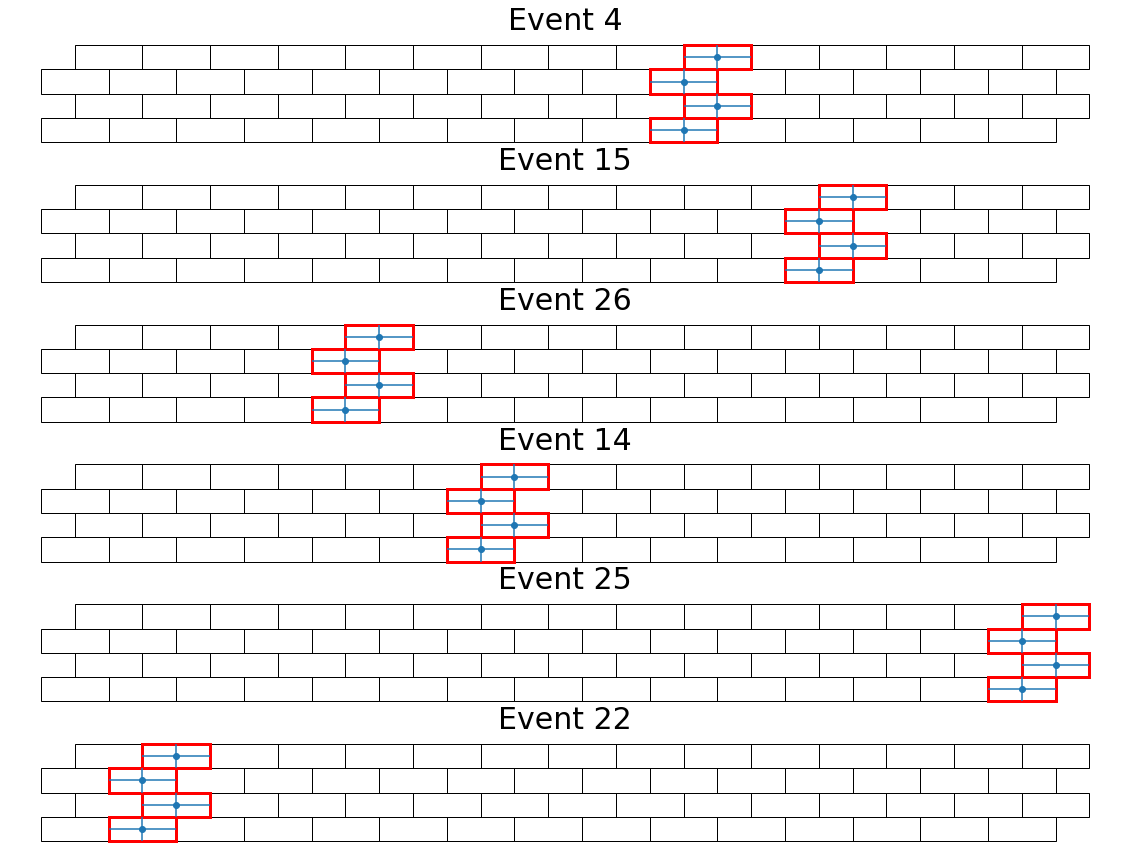

In [27]:
#draw new events
dx = 1
dy = 1/2

fig,ax = plt.subplots(nrows=6,ncols=1,figsize=(20,15))

for i,j in zip(range(6), randomin):
    ax[i].set_title("Event %d" %j,fontsize=30)
    draw_detector(ax[i])
    boxes(ax[i],centres(event[i])[0],centres(event[i])[1])
    ax[i].errorbar(*centres(event[i]),dy/2,dx/2,fmt='o')
    
plt.show()

In [28]:
filtered7.to_csv("dati_LS1.csv",index=False)